# Number Plate Detection From Image

In [1]:
import cv2
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'Tesseract-OCR/tesseract.exe'

In [2]:
def number_plate_from_image(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    number_plate_contours = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)
        if aspect_ratio > 2.0 and aspect_ratio < 5.0 and area > 1000:
            number_plate_contours.append(contour)
    for contour in number_plate_contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        roi = blurred[y:y+h, x:x+w]
        number_plate_text = pytesseract.image_to_string(roi, config='--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 -l eng')
        return number_plate_text
    return ''

In [3]:
number_plate_from_image('static/Testing/Number1.jpg')

'DL7CN5617\n'

# Number Plate Detection from Live Video


In [5]:
cap = cv2.VideoCapture(0)
harcascade = "Haarcascades/haarcascade_russian_plate_number.xml"
cap.set(3, 640)  # width
cap.set(4, 480)  # height
min_area = 500
num = 0

while True:
    success, img = cap.read()  # read the camera frame
    if not success:
        break

    plate_cascade = cv2.CascadeClassifier(harcascade)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(img_gray, 1.1, 4)

    for (x, y, w, h) in plates:
        area = w * h
        if area > min_area:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, "Number Plate", (x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 255), 2)
            img_roi = img[y: y + h, x: x + w]
            cv2.imwrite("static/Temporary Storage/number_plate_{}.jpg".format(num), img_roi)
            num += 1

    # Display the frame with detections
    cv2.imshow('Video', img)

    # Check if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


# Getting License Plates from the Live Video

In [9]:
import os

plates=[]
folder_path = "static/Temporary Storage"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    k = number_plate_from_image(file_path)
    if k not in plates:
        plates.append(k)
    os.remove(file_path)
print(*plates)

# Object Detection from Image

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def objects_from_image(img):
    model = YOLO('yolo model/yolov8x.pt')
    results = model(img, show=False)
    if isinstance(results, list):
        for i, img_result in enumerate(results):
            output_path = "static/processed_image.jpg"
            img_result.save(output_path)

            # Display the image using matplotlib
            img_to_show = mpimg.imread(output_path)
            plt.imshow(img_to_show)
            plt.axis('off')  # Hide the axis
            plt.show()


image 1/1 D:\Project Space\MYFRONTEND\static\Testing\object3.jpg: 384x640 1 person, 23 cars, 1 truck, 706.9ms
Speed: 12.8ms preprocess, 706.9ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)


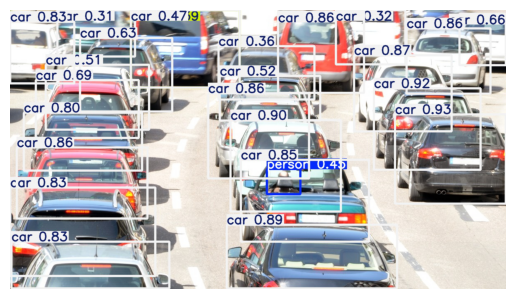

In [13]:
objects_from_image("static/Testing/object3.jpg")

# Object Detection from Live Video

In [19]:
import cv2
from random import randint

# Load YOLO model
dnn = cv2.dnn.readNet(r'yolo model\yolov4-tiny.weights', r'yolo model\yolov4-tiny.cfg')
model = cv2.dnn_DetectionModel(dnn)
model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

# Load class labels
with open(r'yolo model\classes.txt') as f:
    classes = f.read().strip().splitlines()

# Initialize video capture
capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Color map for class labels
color_map = {}

while True:
    success, img = capture.read()  # Read the camera frame
    if not success:
        break
    
    frame = img.copy()  # Make a copy of the original frame
    frame = cv2.flip(frame, 1)  # Flip the frame horizontally
    
    try:
        # Perform object detection
        class_ids, confidences, boxes = model.detect(frame, confThreshold=0.5, nmsThreshold=0.4)

        # Iterate over detected objects
        if class_ids is not None:
            for id, confidence, box in zip(class_ids.flatten(), confidences.flatten(), boxes):
                x, y, w, h = box
                obj_class = classes[id]

                if obj_class not in color_map:
                    color = (randint(0, 255), randint(0, 255), randint(0, 255))
                    color_map[obj_class] = color
                else:
                    color = color_map[obj_class]

                # Draw bounding box and label
                cv2.putText(frame, f'{obj_class.title()} {format(confidence, ".2f")}', (x, y-10), cv2.FONT_HERSHEY_DUPLEX, 1, color, 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            # Display the frame with detections
            cv2.imshow('Video', frame)

            # Check if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    except Exception as e:
        print("Error during detection:", e)

# Release the capture and close all OpenCV windows
capture.release()
cv2.destroyAllWindows()
